In [ ]:
# !pip install skater
# if you face an issue with this you can download skater master from here :https://github.com/oracle/Skater
# go that folder on your command prompt and run 
# python setup.py install
# also if you build skater like that , you'll need to restart your kernel for imports to start working

In [ ]:
# !pip install skater

In [1]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
file=r'/Users/lalitsachan/Dropbox/0.0 Data/census_income.csv'

ci=pd.read_csv(file)
ci=ci.sample(1000)

In [3]:
ci.drop(['education'],axis=1,inplace=True)
ci['Y']=(ci['Y']==' >50K').astype(int)
cat_cols=ci.select_dtypes(['object']).columns

for col in cat_cols:
    freqs=ci[col].value_counts()
    k=freqs.index[freqs>10][:-1]
    for cat in k:
        name=col+'_'+cat
        ci[name]=(ci[col]==cat).astype(int)
    del ci[col]

x=ci.drop(['Y'],1)
y=ci['Y']

In [4]:
y.value_counts()

0    769
1    231
Name: Y, dtype: int64

In [5]:
rf=RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 14, 'max_features': 11, 'n_estimators': 320})

In [6]:
rf.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=14, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=320, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [8]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

2020-03-12 10:16:12,685 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[40/40] features ████████████████████ Time elapsed: 4 seconds

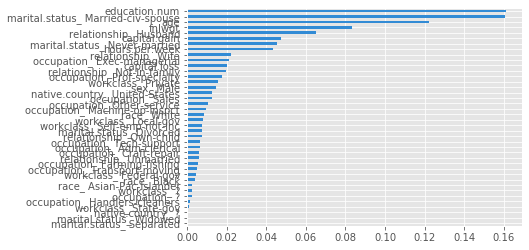

In [9]:
interpreter = Interpretation(x, feature_names=x.columns)
model = InMemoryModel(rf.predict_proba, examples=x)
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True)

In [ ]:
rf.classes_

2020-03-12 10:16:35,331 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[15/15] grid cells ████████████████████ Time elapsed: 1 seconds

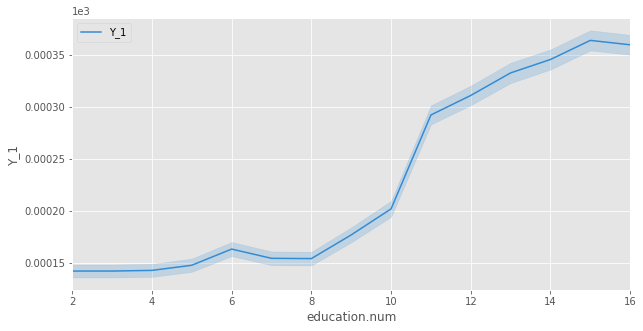

In [10]:
pyint_model = InMemoryModel(rf.predict_proba, examples=x, target_names=['Y_0','Y_1'])
axes_list = interpreter.partial_dependence.plot_partial_dependence(['education.num'],
                                                                   pyint_model, 
                                                                   grid_resolution=30, 
                                                                   with_variance=True,
                                                                   figsize = (10, 5))


2020-03-12 10:19:50,820 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[28/28] grid cells ████████████████████ Time elapsed: 3 seconds

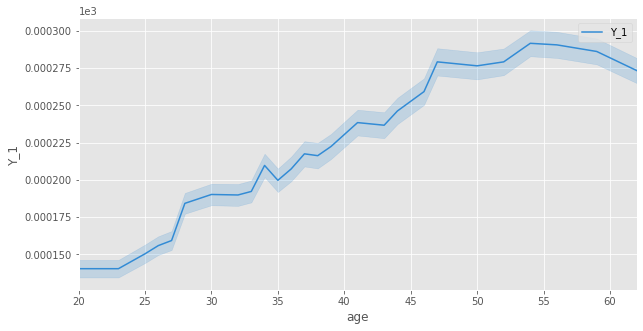

In [11]:
axes_list = interpreter.partial_dependence.plot_partial_dependence(['age'],
                                                                   pyint_model, 
                                                                   grid_resolution=30, 
                                                                   with_variance=True,
                                                                   figsize = (10, 5))

2020-03-12 10:20:52,295 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[60/60] grid cells ████████████████████ Time elapsed: 7 seconds

[[<Figure size 1152x720 with 2 Axes>,

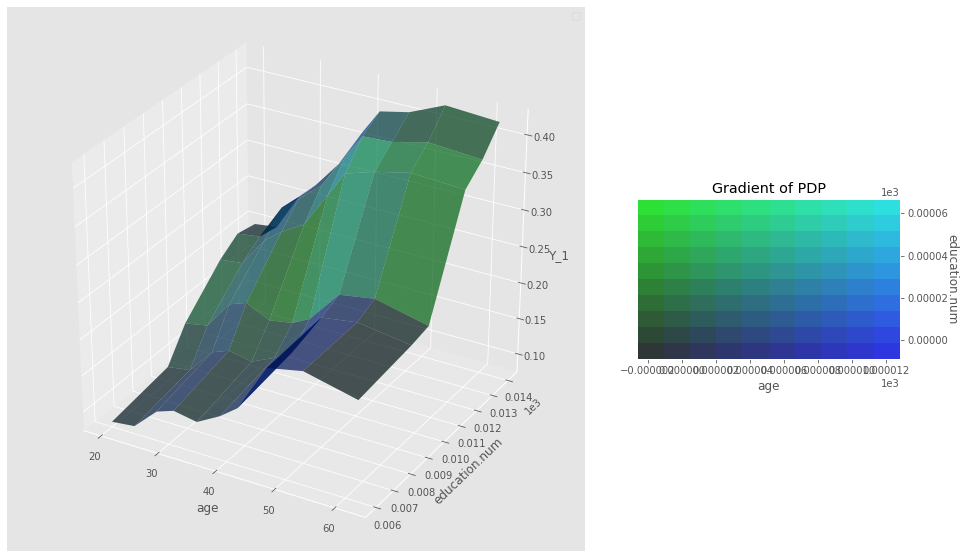

In [12]:
model = InMemoryModel(rf.predict_proba, examples=x, target_names=['Y_0', 'Y_1'])
interpreter.partial_dependence.plot_partial_dependence([('age', 'education.num')], model, 
                                                       grid_resolution=10)

In [14]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.util.dataops import show_in_notebook
exp = LimeTabularExplainer(x.values, 
                           feature_names=x.columns, 
                           discretize_continuous=True, 
                           class_names=['Y_0', 'Y_1'])
exp.explain_instance(x.iloc[500].values, rf.predict_proba).show_in_notebook()

In [23]:
from skater.core.global_interpretation.tree_surrogate import TreeSurrogate

# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(oracle=model,max_depth=6)
y_pred_rf=rf.predict(x)
surrogate_explainer.fit(x, y_pred_rf, use_oracle=True, prune='post', scorer_type='default')

2020-03-12 10:34:12,114 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2020-03-12 10:34:12,118 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2020-03-12 10:34:12,120 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 0.28695218380721155
2020-03-12 10:34:12,167 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [4, 5, 8, 30]
2020-03-12 10:34:12,169 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (1000, 2)
2020-03-12 10:34:12,171 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.297; oracle score 0.135


-0.162

In [24]:
# if you get graphviz error on mac : please install by running this : sudo brew install graphviz
# if that gives error for brew not found , install homebrew
surrogate_explainer.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'],
                                          file_name='simple_tree_pre.png')

2020-03-12 10:34:16,158 - skater.util.dataops - INFO - File Name: simple_tree_pre.png


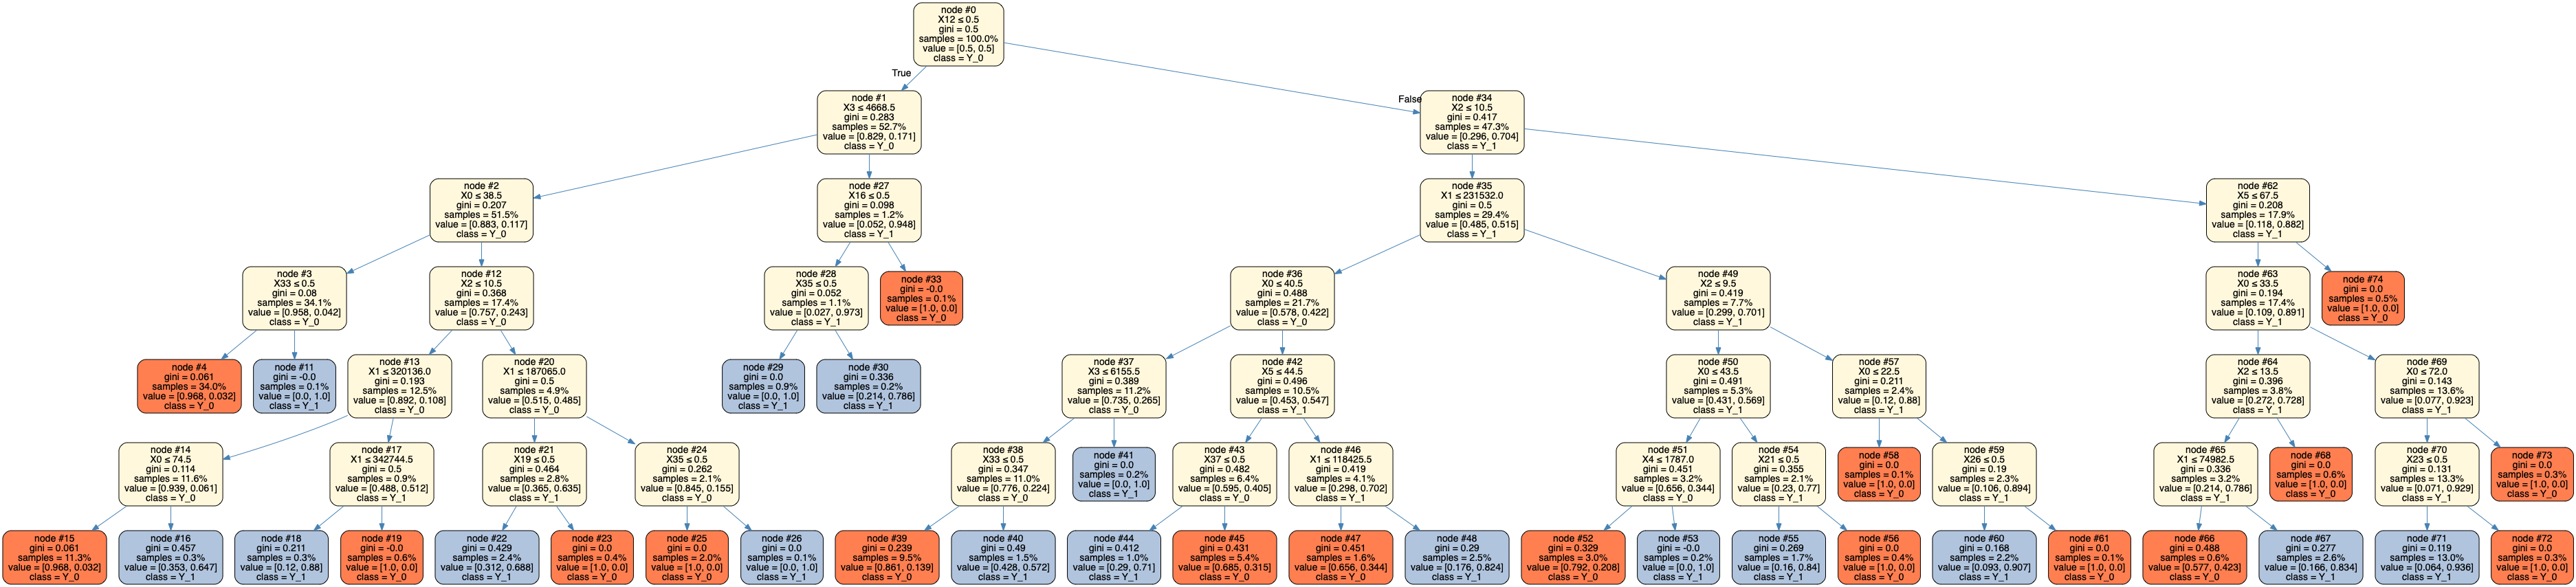

In [25]:
show_in_notebook('simple_tree_pre.png', width=400, height=300)

In [19]:
dict(enumerate(x.columns))

{0: 'age',
 1: 'fnlwgt',
 2: 'education.num',
 3: 'capital.gain',
 4: 'capital.loss',
 5: 'hours.per.week',
 6: 'workclass_ Private',
 7: 'workclass_ Self-emp-not-inc',
 8: 'workclass_ Local-gov',
 9: 'workclass_ ?',
 10: 'workclass_ State-gov',
 11: 'workclass_ Federal-gov',
 12: 'marital.status_ Married-civ-spouse',
 13: 'marital.status_ Never-married',
 14: 'marital.status_ Divorced',
 15: 'marital.status_ Separated',
 16: 'marital.status_ Widowed',
 17: 'occupation_ Prof-specialty',
 18: 'occupation_ Exec-managerial',
 19: 'occupation_ Adm-clerical',
 20: 'occupation_ Craft-repair',
 21: 'occupation_ Other-service',
 22: 'occupation_ Sales',
 23: 'occupation_ Machine-op-inspct',
 24: 'occupation_ ?',
 25: 'occupation_ Transport-moving',
 26: 'occupation_ Handlers-cleaners',
 27: 'occupation_ Farming-fishing',
 28: 'occupation_ Tech-support',
 29: 'relationship_ Husband',
 30: 'relationship_ Not-in-family',
 31: 'relationship_ Own-child',
 32: 'relationship_ Unmarried',
 33: 'relati

In [20]:
from sklearn.metrics import accuracy_score

In [26]:
accuracy_score(rf.predict(x),y)

0.981

In [27]:
accuracy_score(surrogate_explainer.predict(x),y)

0.865